# Question1. Comparing linear and non-linear DR (4 points)

Compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset. Explore how the different features are shown in the DR components. Build a simple prediction model (for example, MLP or Random Forest) to predict the count of total rental bikes and compare the performance of the model with the different DR techniques.

In [1]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# load the ARFF file
data, meta = arff.loadarff('dataset.arff')
df = pd.DataFrame(data)

# convert byte strings to regular strings
for col in df.select_dtypes([object]):
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# detect categorical columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns

# encode categorical columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print(df.head())

   season  year  month  hour  holiday  weekday  workingday  weather  temp  \
0       1   0.0    1.0   0.0        0      6.0           0        0  9.84   
1       1   0.0    1.0   1.0        0      6.0           0        0  9.02   
2       1   0.0    1.0   2.0        0      6.0           0        0  9.02   
3       1   0.0    1.0   3.0        0      6.0           0        0  9.84   
4       1   0.0    1.0   4.0        0      6.0           0        0  9.84   

   feel_temp  humidity  windspeed  casual  registered  count  
0     14.395      0.81        0.0     3.0        13.0   16.0  
1     13.635      0.80        0.0     8.0        32.0   40.0  
2     13.635      0.80        0.0     5.0        27.0   32.0  
3     14.395      0.75        0.0     3.0        10.0   13.0  
4     14.395      0.75        0.0     0.0         1.0    1.0  


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('count', axis=1)
y = df['count']

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

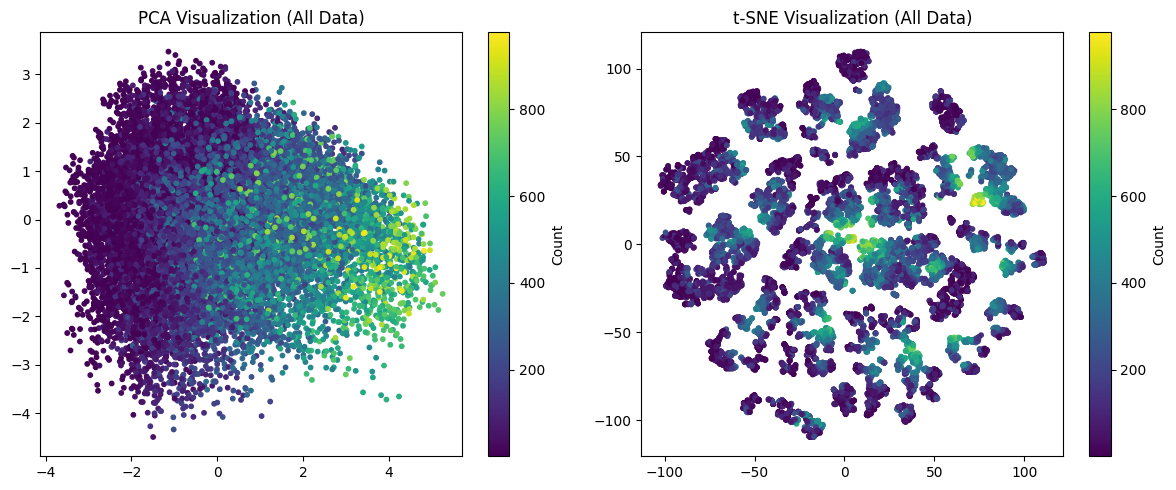

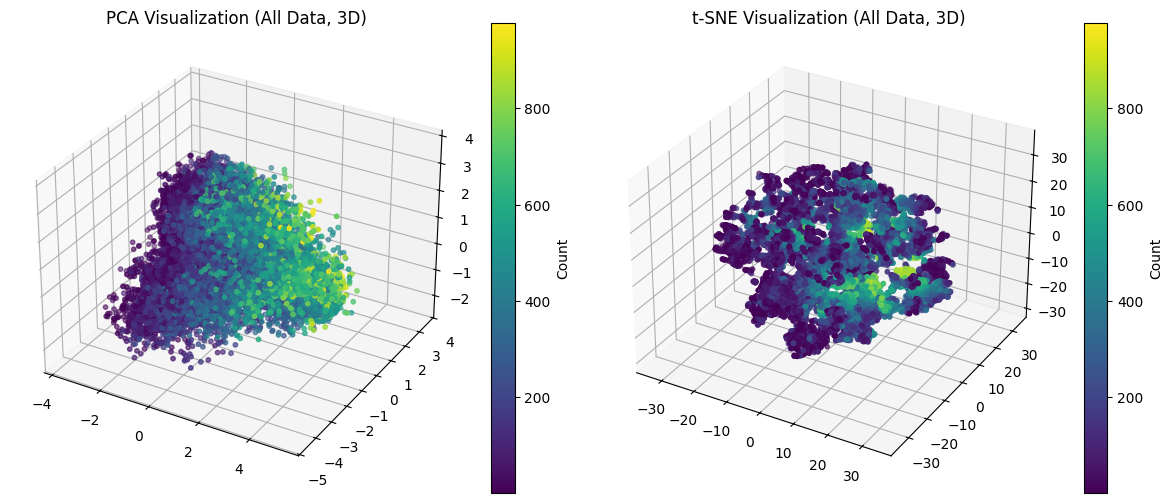

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=2, random_state=0)
X_pca_all = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne_all = tsne.fit_transform(X_scaled)

# visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA visualization
sc1 = axes[0].scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y, cmap='viridis', s=10)
axes[0].set_title("PCA Visualization (All Data)")
fig.colorbar(sc1, ax=axes[0], label='Count')

# t-SNE visualization
sc2 = axes[1].scatter(X_tsne_all[:, 0], X_tsne_all[:, 1], c=y, cmap='viridis', s=10)
axes[1].set_title("t-SNE Visualization (All Data)")
fig.colorbar(sc2, ax=axes[1], label='Count')

plt.tight_layout()
plt.savefig("2D_DR_Visualization.pdf")
plt.show()


# 3D PCA
pca_3d = PCA(n_components=3, random_state=0)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# 3D t-SNE
tsne_3d = TSNE(n_components=3, random_state=0)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# visualization
fig = plt.figure(figsize=(12, 5))

# PCA
ax1 = fig.add_subplot(121, projection='3d')
p = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                c=y, cmap='viridis', s=10)
ax1.set_title("PCA Visualization (All Data, 3D)")
fig.colorbar(p, ax=ax1, label='Count')

# t-SNE
ax2 = fig.add_subplot(122, projection='3d')
t = ax2.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                c=y, cmap='viridis', s=10)
ax2.set_title("t-SNE Visualization (All Data, 3D)")
fig.colorbar(t, ax=ax2, label='Count')

plt.tight_layout()
plt.savefig("3D_DR_Visualization.pdf")
plt.show()

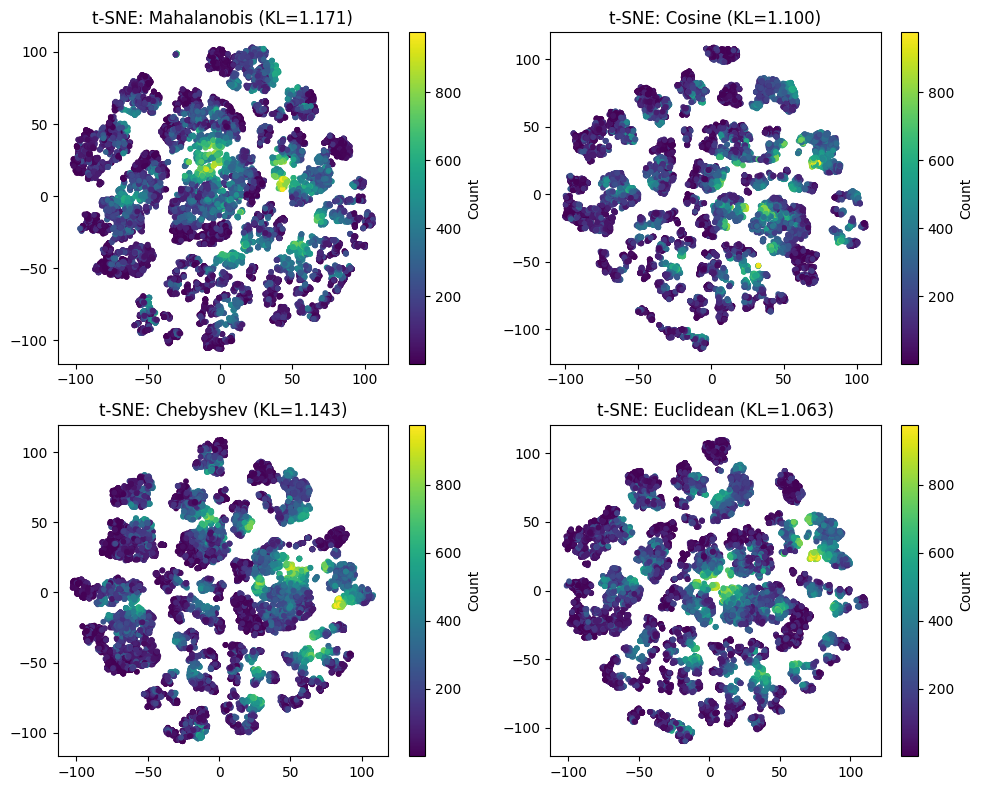

In [ ]:
# Mahalanobis Distance Metric Comparison
V = np.cov(X_scaled, rowvar=False)
eps = 1e-6
V_reg = V + eps * np.eye(V.shape[1])
try:
    VI = np.linalg.inv(V_reg)
except np.linalg.LinAlgError:
    VI = np.linalg.pinv(V_reg) 

metrics = ['mahalanobis', 'cosine', 'chebyshev', 'euclidean']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric in zip(axes.ravel(), metrics):
    kwargs = dict(n_components=2, metric=metric, random_state=0)
    if metric == 'mahalanobis':
        kwargs['metric_params'] = {'VI': VI}

    tsne_tmp = TSNE(**kwargs)
    X_tsne_tmp = tsne_tmp.fit_transform(X_scaled)

    sc = ax.scatter(X_tsne_tmp[:, 0], X_tsne_tmp[:, 1], c=y, cmap='viridis', s=10)
    ax.set_title(f"t-SNE: {metric.capitalize()} (KL={tsne_tmp.kl_divergence_:.3f})")

    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Count')

plt.tight_layout()
plt.savefig("2D_tSNE_Metrics_Comparison.pdf")
plt.show()

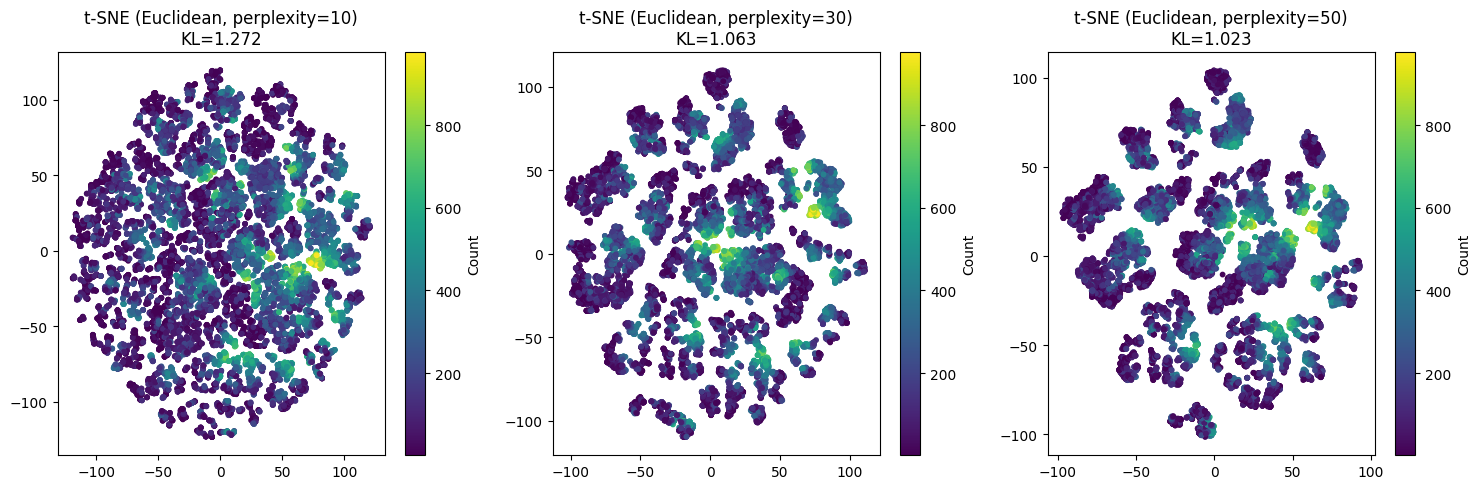

In [ ]:
# Perplexity Comparison
perplexities = [10, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, perp in zip(axes, perplexities):
    tsne_tmp = TSNE(n_components=2, metric='euclidean', perplexity=perp, random_state=0)
    X_tsne_tmp = tsne_tmp.fit_transform(X_scaled)

    sc = ax.scatter(X_tsne_tmp[:, 0], X_tsne_tmp[:, 1], c=y, cmap='viridis', s=10)
    ax.set_title(f"t-SNE (Euclidean, perplexity={perp})\nKL={tsne_tmp.kl_divergence_:.3f}")

    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Count')

plt.tight_layout()
plt.savefig("2D_tSNE_Perplexity_Comparison.pdf")
plt.show()

In [ ]:
# split the data into train and test sets
# warning: information leak!
idx = np.arange(len(y))
X_train_scaled, X_test_scaled, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, idx, test_size=0.2, random_state=0
)

# get the corresponding reduced data
X_train_pca = X_pca_all[idx_train]
X_test_pca  = X_pca_all[idx_test]

X_train_tsne = X_tsne_all[idx_train]
X_test_tsne  = X_tsne_all[idx_test]

                 PC1       PC2
temp        0.482092  0.353593
feel_temp   0.476836  0.368462
casual      0.434440 -0.149216
registered  0.383283 -0.141790
hour        0.244702 -0.275031


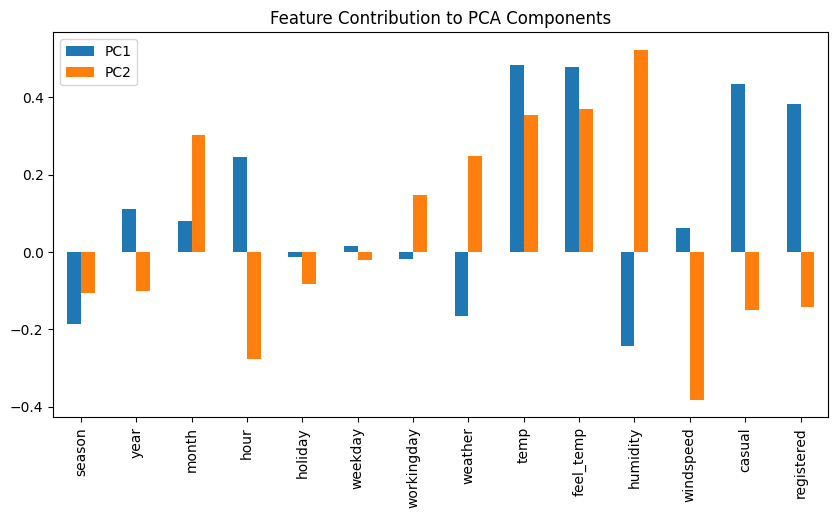

In [6]:
# loading the PCA components into a DataFrame for better visualization
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=['PC1', 'PC2']
)
print(pca_components.T.sort_values(by='PC1', ascending=False).head())

pca_components.T.plot(kind='bar', figsize=(10,5))
plt.title('Feature Contribution to PCA Components')
plt.savefig("Feature_Contribution_to_PCA_Components.pdf")
plt.show()

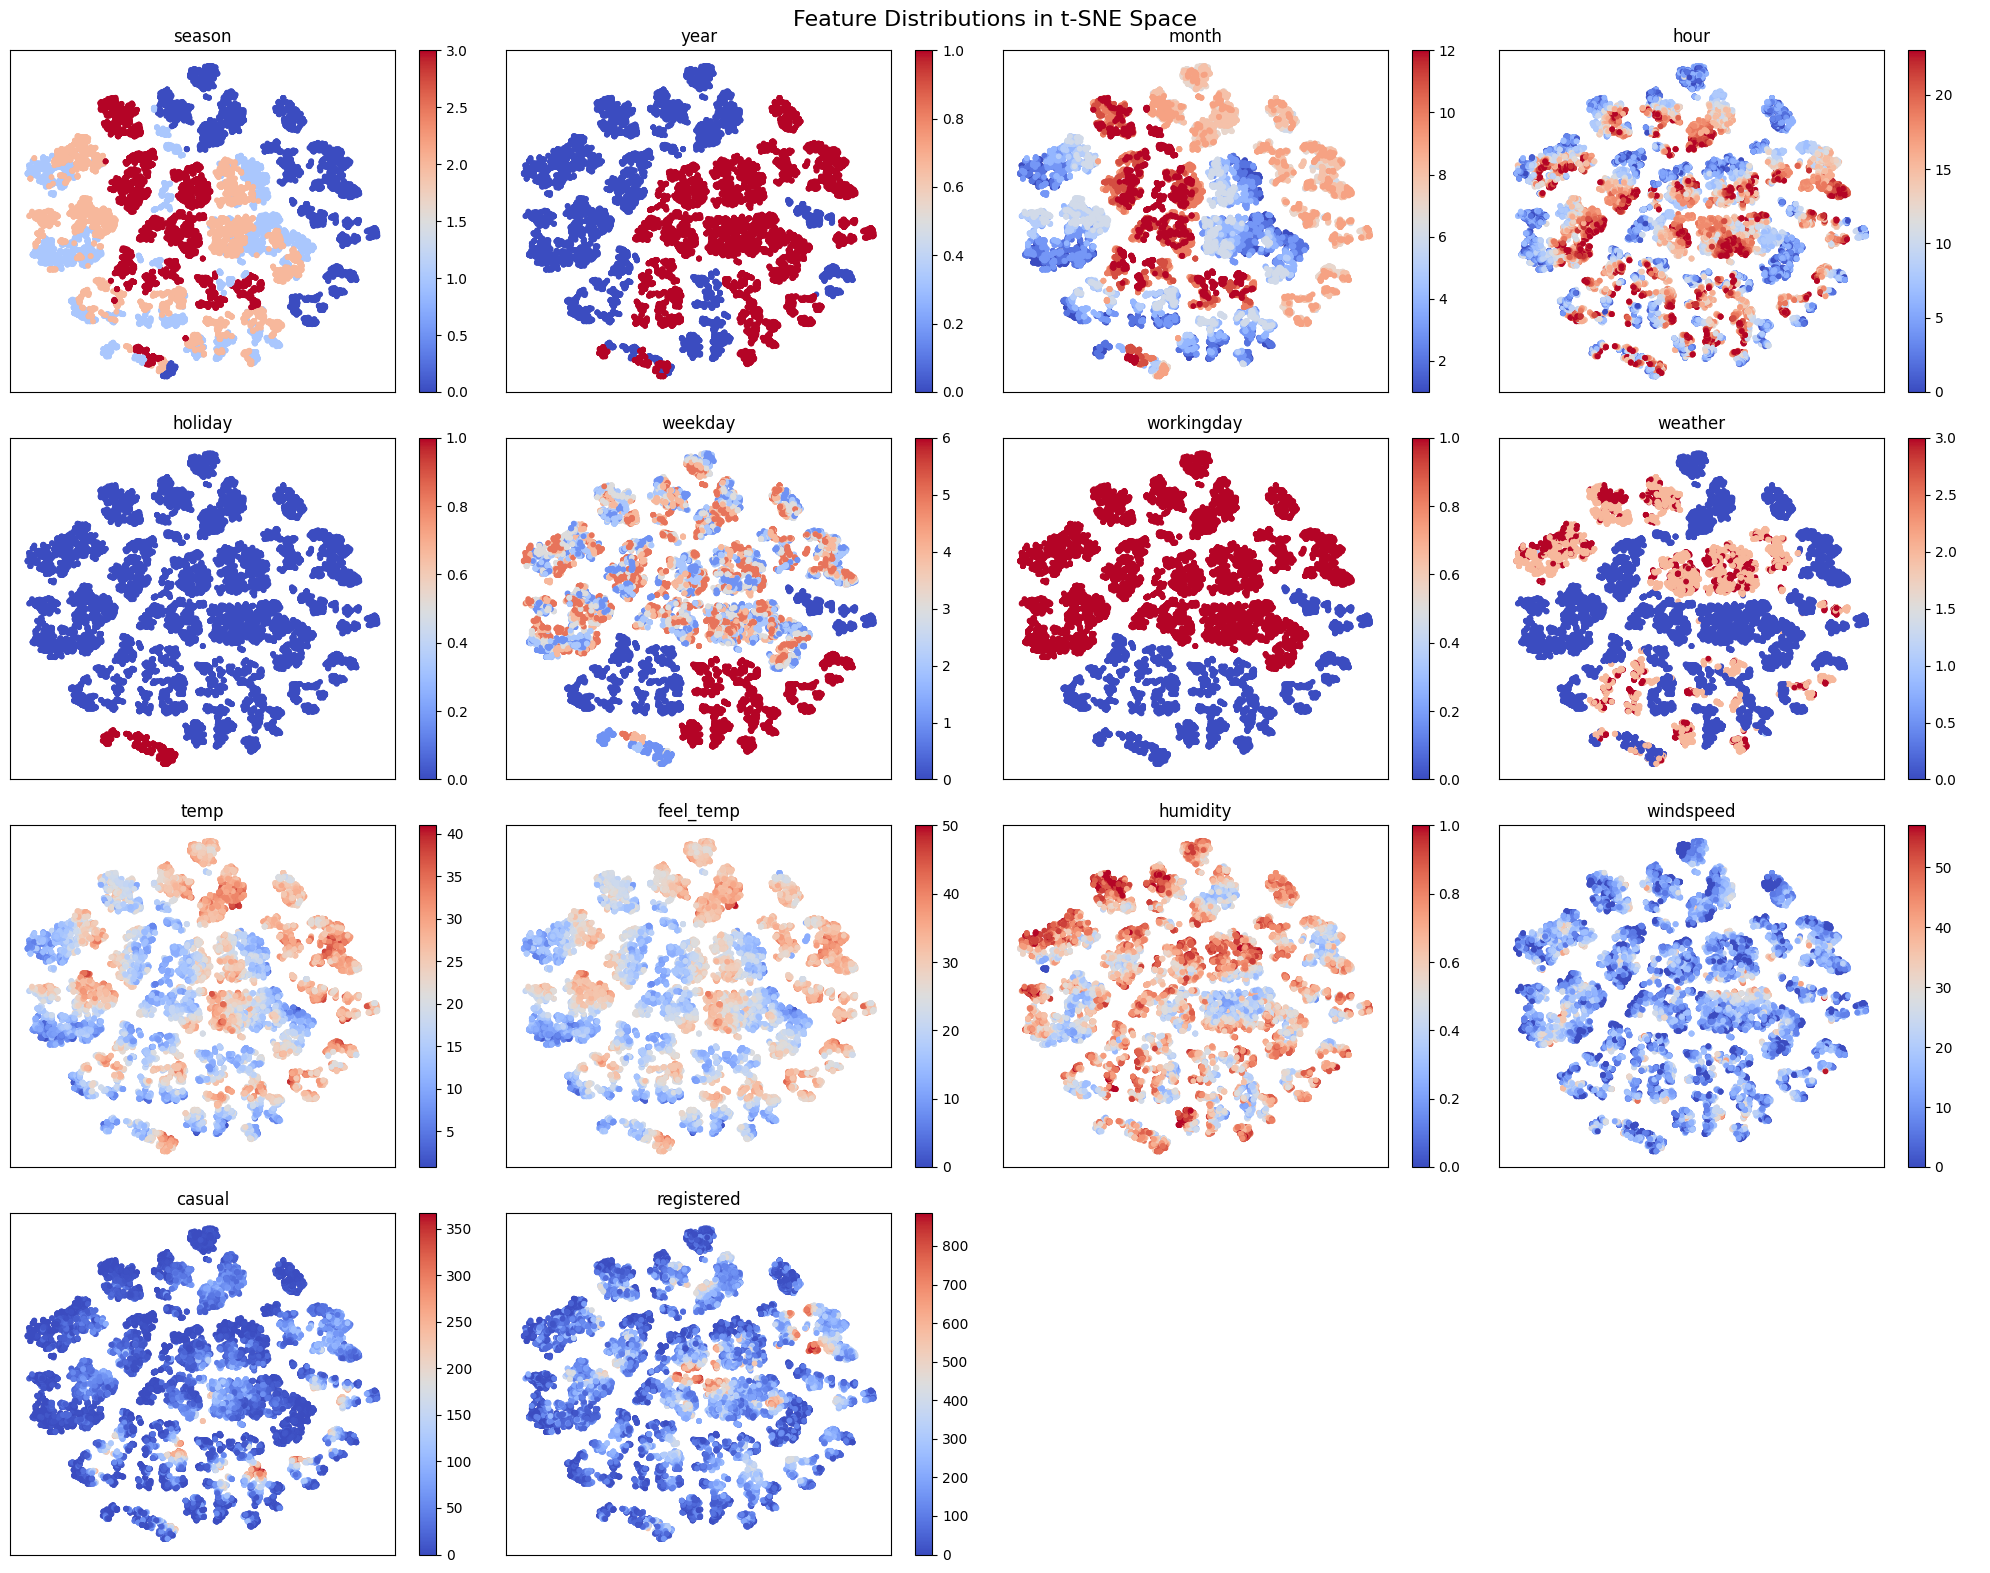

In [7]:
import math

# select features to plot
features_to_plot = [c for c in X.columns if c != 'count']
n_features = len(features_to_plot)

# plotting
cols = 4
rows = math.ceil(n_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, f in enumerate(features_to_plot):
    sc = axes[i].scatter(
        X_tsne_all[:, 0], X_tsne_all[:, 1],
        c=X[f].values[:len(X_tsne_all)],
        cmap='coolwarm', s=10
    )
    axes[i].set_title(f)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    plt.colorbar(sc, ax=axes[i])

# if there are unused subplots, turn them off
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Feature Distributions in t-SNE Space", fontsize=16)
plt.tight_layout()
plt.savefig("Feature_Distributions_in_tSNE_Space.pdf")
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# function to train and evaluate MLP model
def evaluate_mlp_model(Xtr, Xte, ytr, yte, name=""):
    """
    Trains and evaluates an MLP regressor model.
    """
    mlp = MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    
    mlp.fit(Xtr, ytr)
    y_pred = mlp.predict(Xte)
    
    rmse = mean_squared_error(yte, y_pred)
    mae = mean_absolute_error(yte, y_pred)
    r2 = r2_score(yte, y_pred)
    
    print(f"{name:<12}:     RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
    return rmse, mae, r2

PCA(2)      :     RMSE: 11405.747 | MAE: 74.106 | R2: 0.658
PCA(3)      :     RMSE: 7294.485 | MAE: 58.085 | R2: 0.781
t-SNE(2)    :     RMSE: 15044.122 | MAE: 91.527 | R2: 0.549
t-SNE(3)    :     RMSE: 7371.634 | MAE: 64.140 | R2: 0.779


,Method,n_components,RMSE,MAE,R2,Time_sec
0,PCA,2,11405.746853,74.105515,0.658194,0.836313
1,PCA,3,7294.485355,58.085068,0.781400,1.593369
2,t-SNE,2,15044.121747,91.527500,0.549160,22.773699
3,t-SNE,3,7371.634196,64.140490,0.779088,30.847760


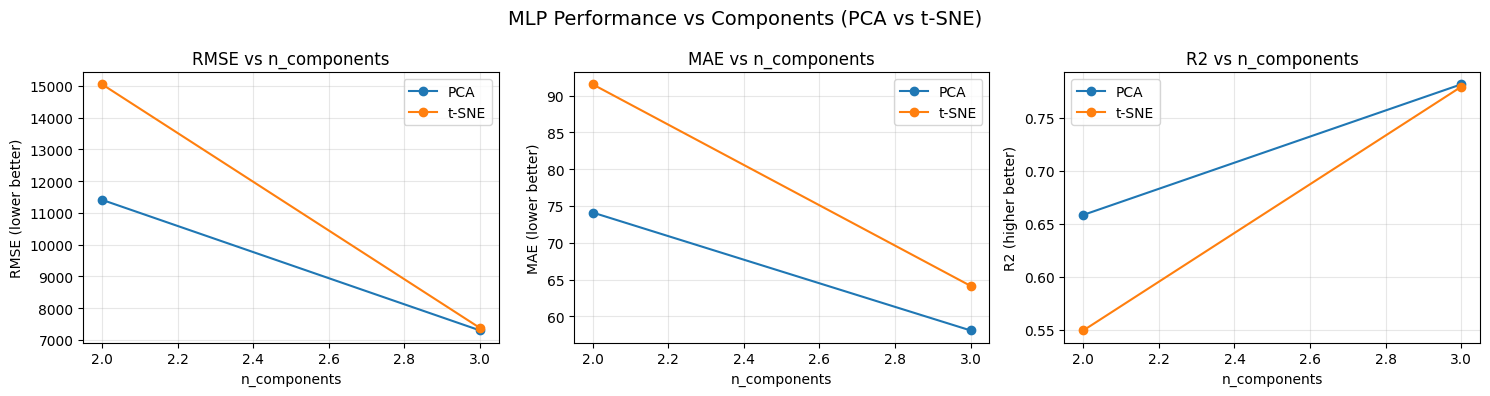

In [ ]:
import time

components = [2,3]

rows = []

# PCA
for n in components:
    t0 = time.time()
    X_all_pca = PCA(n_components=n, random_state=0).fit_transform(X_scaled)
    X_train_pca = X_all_pca[idx_train]
    X_test_pca  = X_all_pca[idx_test]
    rmse, mae, r2 = evaluate_mlp_model(X_train_pca, X_test_pca, y_train, y_test, f"PCA({n})")
    rows.append(("PCA", n, rmse, mae, r2, time.time() - t0))

# t-SNE
for n in components:
    t0 = time.time()
    X_all_tsne = TSNE(n_components=n, random_state=0).fit_transform(X_scaled)
    X_train_tsne = X_all_tsne[idx_train]
    X_test_tsne  = X_all_tsne[idx_test]
    rmse, mae, r2 = evaluate_mlp_model(X_train_tsne, X_test_tsne, y_train, y_test, f"t-SNE({n})")
    rows.append(("t-SNE", n, rmse, mae, r2, time.time() - t0))

# summarize results
df_comp = pd.DataFrame(rows, columns=["Method", "n_components", "RMSE", "MAE", "R2", "Time_sec"])
display(df_comp.sort_values(["Method", "n_components"]))

# plotting the comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for meth, ax, metric in zip(
    ["RMSE", "MAE", "R2"],
    axes,
    ["RMSE", "MAE", "R2"]
):
    sub_pca  = df_comp[df_comp["Method"] == "PCA"]
    sub_tsne = df_comp[df_comp["Method"] == "t-SNE"]

    ax.plot(sub_pca["n_components"], sub_pca[metric], marker="o", label="PCA")
    ax.plot(sub_tsne["n_components"], sub_tsne[metric], marker="o", label="t-SNE")
    ax.set_xlabel("n_components")
    ax.set_title(f"{metric} vs n_components")
    ax.grid(True, alpha=0.3)
    if metric in ["RMSE", "MAE"]:
        ax.set_ylabel(metric + " (lower better)")
    else:
        ax.set_ylabel(metric + " (higher better)")
    ax.legend()

plt.suptitle("MLP Performance vs Components (PCA vs t-SNE)", fontsize=14)
plt.tight_layout()
plt.savefig("MLP_Performance_vs_Components_PCA_vs_tSNE.pdf")
plt.show()